In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting train-labels-idx1-ubyte.gz
Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mnist.train.__dict__.keys()

dict_keys(['_index_in_epoch', '_epochs_completed', '_images', '_num_examples', '_labels'])

In [4]:
train_X = mnist.train._images.reshape((-1,28,28,1))
train_Y =mnist.train._labels
train_X.shape

(55000, 28, 28, 1)

In [5]:
test_X = mnist.test._images.reshape((-1,28,28,1))
test_Y =mnist.test._labels
test_X.shape

(10000, 28, 28, 1)

In [6]:
def get_one_triplet(input_data, input_labels, n_labels):
    index = np.random.choice(n_labels, 2, replace=False)
    label_positive = index[0]
    label_negative = index[1]

    indexes = np.where(input_labels == index[0])[0]
    np.random.shuffle(indexes)

    data_anchor = input_data[indexes[0], :, :, :]
    data_positive = input_data[indexes[1], :, :, :]

    indexes = np.where(input_labels == index[1])[0]
    np.random.shuffle(indexes)
    data_negative = input_data[indexes[0], :, :, :]

    return data_anchor, data_positive, data_negative, label_positive, label_positive, label_negative

In [7]:
def convolutionize(x, conv_w, h = 1):
    return tf.nn.conv2d(input = x, filter = conv_w, strides = [1, h, h, 1], padding = 'SAME')

def pooling(wx):
    return tf.nn.max_pool(wx, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

def create_network(X, scope='conv',reuse=False):
    with tf.variable_scope(scope,reuse=reuse):
        w1 = tf.Variable(tf.random_normal([3, 3, 1, 2], stddev = 0.5))
        b1 = tf.Variable(tf.zeros(shape = [2]))
        w2 = tf.Variable(tf.random_normal([3, 3, 2, 4], stddev = 0.5))
        b2 = tf.Variable(tf.zeros(shape = [4]))
        w3 = tf.Variable(tf.random_normal([3, 3, 4, 8], stddev = 0.5))
        b3 = tf.Variable(tf.zeros(shape = [8]))
        w4 = tf.Variable(tf.random_normal([128, 2], stddev = 0.5))
        b4 = tf.Variable(tf.zeros(shape = [2]))

        conv1 = pooling(tf.nn.relu(convolutionize(X, w1) + b1))
        conv2 = pooling(tf.nn.relu(convolutionize(conv1, w2) + b2))
        conv3 = pooling(tf.nn.relu(convolutionize(conv2, w3) + b3))
        conv3 = tf.reshape(conv3, [-1, 128])
        return tf.matmul(conv3, w4) + b4
    
def compute_euclidean_distance(x, y):
    d = tf.square(tf.subtract(x, y))
    return tf.sqrt(tf.reduce_sum(d))

def compute_triplet_loss(anchor_feature, positive_feature, negative_feature, margin=0.01):
    d_p_squared = tf.square(compute_euclidean_distance(anchor_feature, positive_feature))
    d_n_squared = tf.square(compute_euclidean_distance(anchor_feature, negative_feature))
    loss = tf.maximum(0., d_p_squared - d_n_squared + margin)
    return tf.reduce_mean(loss), tf.reduce_mean(d_p_squared), tf.reduce_mean(d_n_squared)
    
class Siamese:
    def __init__(self):
        self.ANCHOR = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.POSITIVE = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.NEGATIVE = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.Y_ANCHOR = tf.placeholder(tf.int32, [None])
        self.Y_POSITIVE = tf.placeholder(tf.int32, [None])
        self.Y_NEGATIVE = tf.placeholder(tf.int32, [None])
        
        self.output_anchor = create_network(self.ANCHOR)
        self.output_positive = create_network(self.POSITIVE,reuse=True)
        self.output_negative = create_network(self.NEGATIVE,reuse=True)
        
        self.cost, positives, negatives = compute_triplet_loss(self.output_anchor, 
                                                          self.output_positive, 
                                                          self.output_negative)
        self.optimizer = tf.train.GradientDescentOptimizer(1e-4).minimize(self.cost)

In [8]:
sess = tf.InteractiveSession()
model = Siamese()
sess.run(tf.global_variables_initializer())

In [9]:
BATCH_SIZE = 128
EPOCH = 10

for i in range(EPOCH):
    batch_anchor = np.zeros((BATCH_SIZE,28,28,1))
    batch_positive = np.zeros((BATCH_SIZE,28,28,1))
    batch_negative = np.zeros((BATCH_SIZE,28,28,1))
    batch_y_anchor = np.zeros((BATCH_SIZE))
    batch_y_positive = np.zeros((BATCH_SIZE))
    batch_y_negative = np.zeros((BATCH_SIZE))
    for k in range(BATCH_SIZE):
        batch_anchor[k], batch_positive[k], batch_negative[k], batch_y_anchor[k], batch_y_positive[k], batch_y_negative[k] = get_one_triplet(train_X, train_Y, 10)
    loss, _ = sess.run([model.cost,model.optimizer],
                       feed_dict={model.ANCHOR:batch_anchor,
                                  model.POSITIVE:batch_positive,
                                  model.NEGATIVE:batch_negative,
                                  model.Y_ANCHOR:batch_y_anchor,
                                  model.Y_POSITIVE:batch_y_positive,
                                  model.Y_NEGATIVE:batch_y_negative})
    print('epoch: %d, loss: %f'%(i+1,loss))

epoch: 1, loss: 0.000000
epoch: 2, loss: 0.000000
epoch: 3, loss: 0.000000
epoch: 4, loss: 0.000000
epoch: 5, loss: 0.000000
epoch: 6, loss: 0.000000
epoch: 7, loss: 0.000000
epoch: 8, loss: 0.000000
epoch: 9, loss: 0.000000
epoch: 10, loss: 0.000000


In [10]:
embed = model.output_positive.eval({model.POSITIVE: test_X})

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import offsetbox

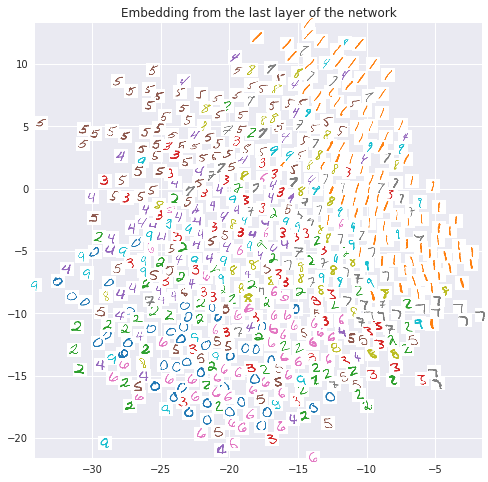

In [12]:
x_test = mnist.test.images.reshape([-1, 28, 28])
y_test = mnist.test.labels

ax_min = np.min(embed,0)
ax_max = np.max(embed,0)
ax_dist_sq = np.sum((ax_max-ax_min)**2)
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
colormap = plt.get_cmap('tab10')
shown_images = np.array([[1., 1.]])
for i in range(embed.shape[0]):
    dist = np.sum((embed[i] - shown_images)**2, 1)
    if np.min(dist) < 3e-4*ax_dist_sq:
        continue
    shown_images = np.r_[shown_images, [embed[i]]]
    patch_to_color = np.expand_dims(x_test[i], -1)
    patch_to_color = np.tile(patch_to_color, (1, 1, 3))
    patch_to_color = (1-patch_to_color) * (1,1,1) + patch_to_color * colormap(y_test[i]/10.)[:3]
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(patch_to_color, zoom=0.5, cmap=plt.cm.gray_r),
        xy=embed[i], frameon=False
    )
    ax.add_artist(imagebox)

plt.axis([ax_min[0], ax_max[0], ax_min[1], ax_max[1]])
plt.title('Embedding from the last layer of the network')
plt.show()